In [1]:
import numpy as np
import torch
import cv2
# import custom files:
import utility.image_processing as ip
import utility.io_processing as iop
import utility.visualization as visualization
import utility.peggnet_model as peggnet
import utility.saving as saving
import utility.grasp_detection as grasp_detection
print("Everything imported")

Everything imported


In [2]:
state_dict = "output/models/241029_0932_/epoch_05_iou_0.70_statedict.pt"
rgb = "test/pcd0301r.png"
depth = "test/pcd0301d.tiff"
output = ""
use_rgb = True
use_depth = True
vis = True
save = False
output_dir = ""

In [3]:
input_channels = 3*use_rgb + use_depth
print('Input channels: {}'.format(input_channels))
# Load the images
rgb = cv2.imread(rgb, cv2.IMREAD_UNCHANGED)
depth = cv2.imread(depth, cv2.IMREAD_UNCHANGED)
assert rgb is not None, 'RGB image not loaded'
assert depth is not None, 'Depth image not loaded'
print('Images loaded')
rgb, depth, mask = ip.process_rgbd_inpaint(rgb, depth)
print('Images processed')
# Prepare the input
input_img = iop.rgbd_input_processing(
    rgb, depth,
    use_depth=use_depth, use_rgb=use_rgb
)
print('Input prepared')
# Load the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device: {}'.format(device))
input_img = input_img.to(device)
print('Loading model from state dict {}'.format(state_dict))
net = peggnet.PEGG_NET(input_channels=input_channels)
# try:
net.load_state_dict(
    torch.load(state_dict, weights_only=True, map_location=device)
)
# except:
#     net.load_state_dict(torch.load(args.state_dict, map_location=device))
assert net is not None, 'Model not loaded'
net.to(device)
print('Model loaded')

Input channels: 4
Images loaded
Images processed
(3, 480, 480)
(480, 480)
(1, 4, 480, 480)
Input prepared
Using device: cuda
Loading model from state dict output/models/241029_0932_/epoch_05_iou_0.70_statedict.pt
Model loaded


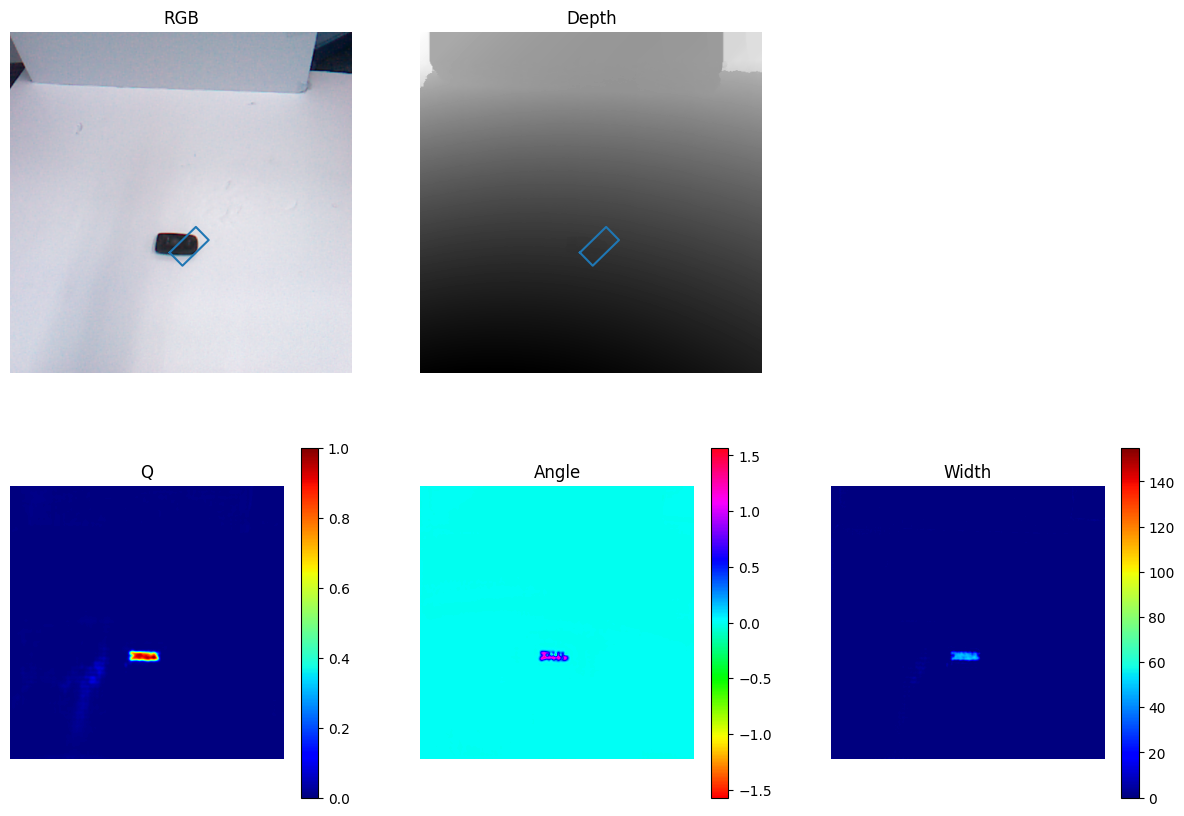

In [4]:
# Run the model
net.eval()
with torch.no_grad():
    pos_output, cos_output, sin_output, width_output = net(input_img)
    q_img, ang_img, width_img = iop.process_raw_output(
        pos_output, cos_output, sin_output, width_output
    )
    if vis:
        visualization.plot_output_full(
            rgb, depth, q_img, ang_img, width_img, 5
        )
    if save:
        assert output_dir is not None, 'Output save directory not specified'
        saving.save_results(
            rgb, q_img, ang_img, depth_img=depth,
            no_grasps=5, grasp_width_img=width_img, save_dir=output_dir
        )

In [1]:
import numpy as np
import torch
import cv2
# import custom files:
import utility.image_processing as ip
import utility.io_processing as iop
import utility.visualization as visualization
import utility.peggnet_model as peggnet
import utility.saving as saving
import utility.grasp_detection as grasp_detection
print("Everything imported")

Everything imported


In [2]:
state_dict = "output/models/241029_0932_/epoch_05_iou_0.70_statedict.pt"
rgb = "test/pcd0301r.png"
depth = "test/pcd0301d.tiff"
output = ""
use_rgb = True
use_depth = True
vis = True
save = False
output_dir = ""

In [3]:
input_channels = 3*use_rgb + use_depth
print('Input channels: {}'.format(input_channels))
# Load the images
rgb = cv2.imread(rgb, cv2.IMREAD_UNCHANGED)
depth = cv2.imread(depth, cv2.IMREAD_UNCHANGED)
assert rgb is not None, 'RGB image not loaded'
assert depth is not None, 'Depth image not loaded'
print('Images loaded')
rgb, depth, mask = ip.process_rgbd_inpaint(rgb, depth)
print('Images processed')
# Prepare the input
input_img = iop.rgbd_input_processing(
    rgb, depth,
    use_depth=use_depth, use_rgb=use_rgb
)
print('Input prepared')
# Load the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device: {}'.format(device))
input_img = input_img.to(device)
print('Loading model from state dict {}'.format(state_dict))
net = peggnet.PEGG_NET(input_channels=input_channels)
# try:
net.load_state_dict(
    torch.load(state_dict, weights_only=True, map_location=device)
)
# except:
#     net.load_state_dict(torch.load(args.state_dict, map_location=device))
assert net is not None, 'Model not loaded'
net.to(device)
print('Model loaded')

Input channels: 4
Images loaded
Images processed
(3, 480, 480)
(480, 480)
(1, 4, 480, 480)
Input prepared
Using device: cuda
Loading model from state dict output/models/241029_0932_/epoch_05_iou_0.70_statedict.pt
Model loaded


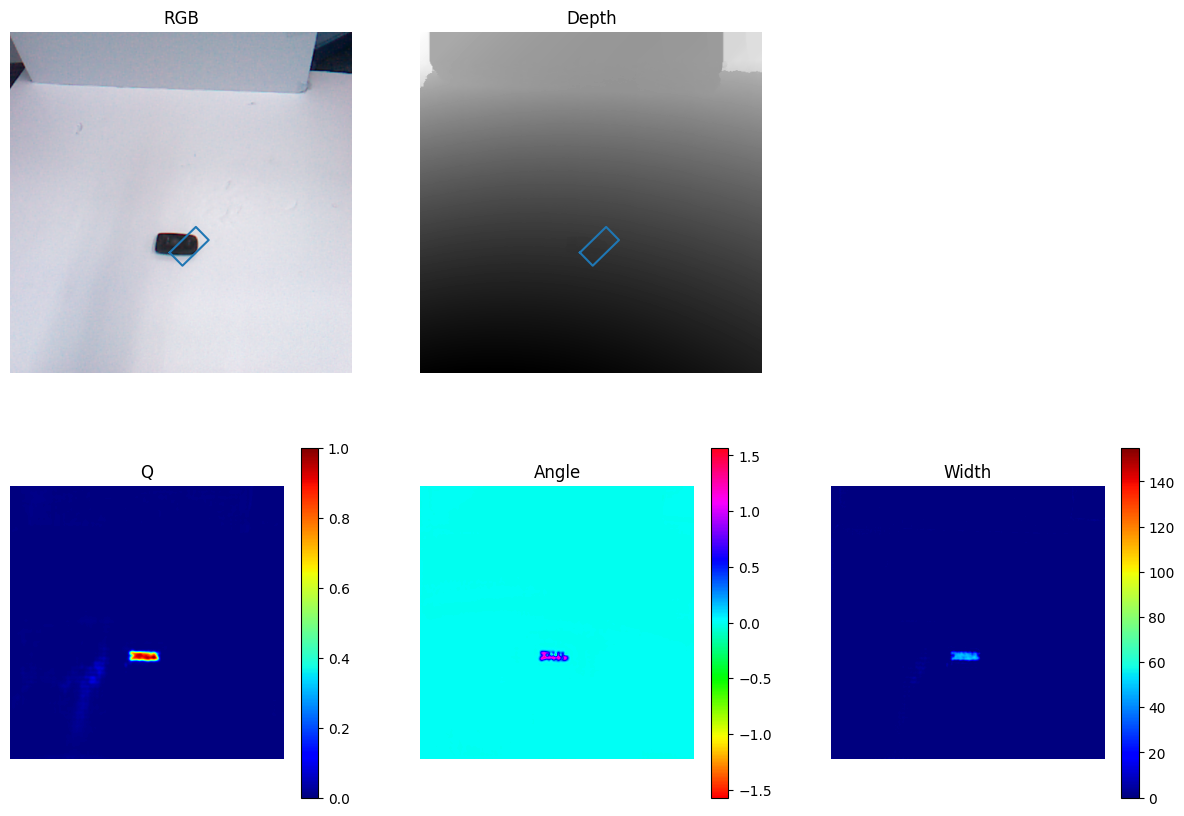

In [4]:
# Run the model
net.eval()
with torch.no_grad():
    pos_output, cos_output, sin_output, width_output = net(input_img)
    q_img, ang_img, width_img = iop.process_raw_output(
        pos_output, cos_output, sin_output, width_output
    )
    if vis:
        visualization.plot_output_full(
            rgb, depth, q_img, ang_img, width_img, 5
        )
    if save:
        assert output_dir is not None, 'Output save directory not specified'
        saving.save_results(
            rgb, q_img, ang_img, depth_img=depth,
            no_grasps=5, grasp_width_img=width_img, save_dir=output_dir
        )